In [2]:
# import Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

#### Reading Data

In [3]:
titanic=pd.read_csv('titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Cleaning Data

In [4]:
# Drop rows with missing 'Sex' or 'Survived' (if any exist)
titanic.dropna(subset=['Sex', 'Survived'])

# Drop irrelevant columns
titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Handle missing values
# Fill 'Age', and 'Fare' with median values

titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].median())

# Convert categorical variables
titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})

# Convert the 'Embarked' column (which contains categorical values like 'C', 'Q', 'S') into dummy variables
# It creates new columns for each unique value in the 'Embarked' column, such as:Embarked_C, Embarked_Q, Embarked_S
# Each of these columns will have values 0 or 1 indicating the presence of that category for a given row
embarked_dummies = pd.get_dummies(titanic['Embarked'], prefix='Embarked')

# Adds the newly created dummy columns to the original titanic DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

#delete the orginal Embarked column 
titanic = titanic.drop('Embarked', axis=1)


#### Separate features and target

In [5]:
# Separate features and target
X = titanic.drop('Survived', axis=1) # Drop Survived and assigning all remening columns to X
y = titanic['Survived'] # assigning Survived to y as dependent variable


#### Split data and train model

In [6]:
# Split into training_full (80%) and test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42)

# Split training_full into training (80% of training_full, 64% of total) ) and development (20%, 16% of total)
X_train, X_dev, y_train, y_dev = train_test_split(
   X_train_full, y_train_full, test_size=0.2, random_state=42
)

In [7]:
# Train unrestricted tree
tree_unrestricted = DecisionTreeClassifier(random_state=42)
tree_unrestricted.fit(X_train, y_train)

# Evaluate on development set
dev_accuracy = accuracy_score(y_dev, tree_unrestricted.predict(X_dev))
print(f"Development Accuracy (No Depth Limit): {dev_accuracy:.2f}")


Development Accuracy (No Depth Limit): 0.78


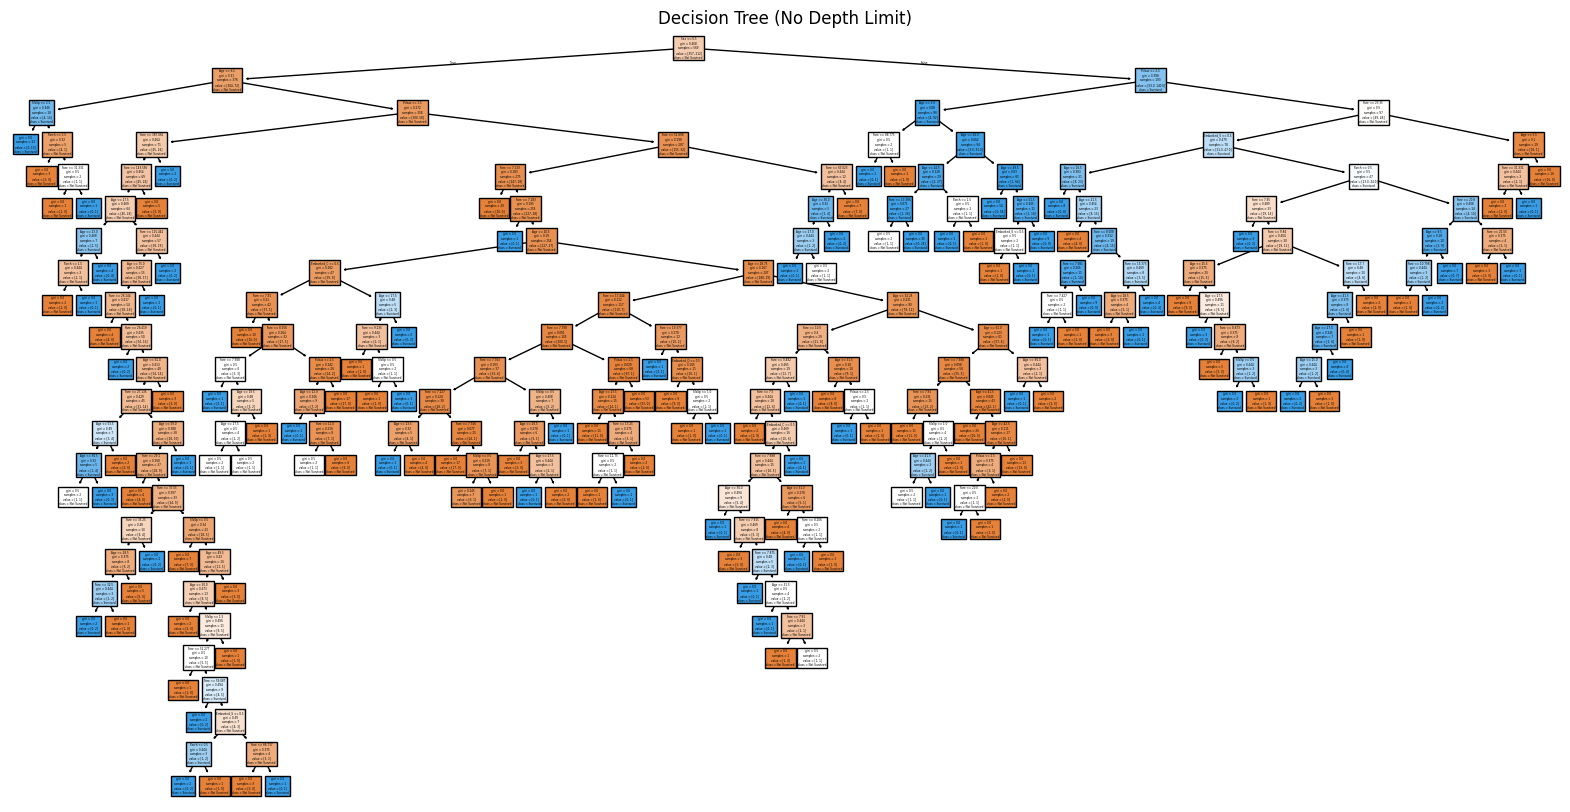

In [8]:
# Plot full decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_unrestricted, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree (No Depth Limit)")
plt.show()

In [9]:
# Evaluate on development set
y_dev_pred = tree_unrestricted.predict(X_dev)
accuracy_unrestricted = accuracy_score(y_dev, y_dev_pred)
print(f"Unrestricted Tree Dev Accuracy: {accuracy_unrestricted:.2f}")

Unrestricted Tree Dev Accuracy: 0.78


In [10]:
train_accuracies = []
dev_accuracies = []
for max_depth in range(2, 11):
   # Train tree with current max_depth
   tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
   tree.fit(X_train, y_train)

# Record accuracies
   train_acc = accuracy_score(y_train, tree.predict(X_train))
   dev_acc = accuracy_score(y_dev, tree.predict(X_dev))
   train_accuracies.append(train_acc)
   dev_accuracies.append(dev_acc)
   print(f"max_depth={max_depth}: Train Acc={train_acc:.2f}, Dev Acc={dev_acc:.2f}")


max_depth=2: Train Acc=0.80, Dev Acc=0.82
max_depth=3: Train Acc=0.83, Dev Acc=0.83
max_depth=4: Train Acc=0.84, Dev Acc=0.83
max_depth=5: Train Acc=0.86, Dev Acc=0.82
max_depth=6: Train Acc=0.88, Dev Acc=0.78
max_depth=7: Train Acc=0.89, Dev Acc=0.83
max_depth=8: Train Acc=0.91, Dev Acc=0.82
max_depth=9: Train Acc=0.92, Dev Acc=0.83
max_depth=10: Train Acc=0.93, Dev Acc=0.80


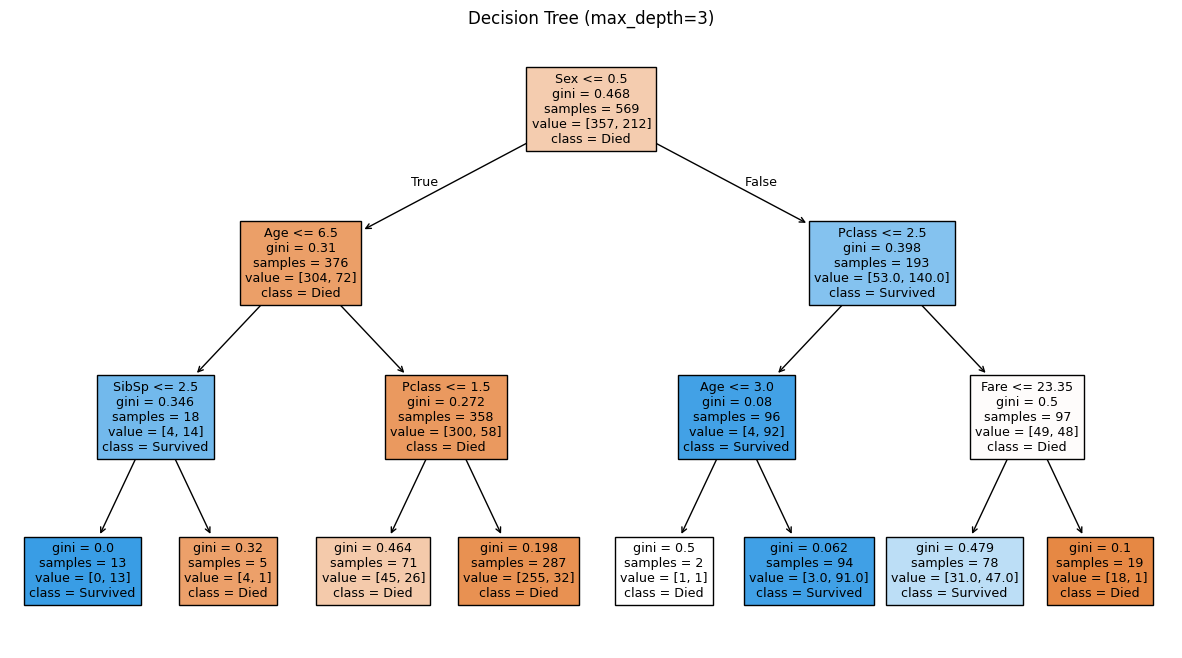

In [11]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

plt.figure(figsize=(15, 8))
plot_tree(tree,
           filled=True,
           feature_names=X.columns,
           class_names=['Died', 'Survived']
       )
plt.title("Decision Tree (max_depth=3)")
plt.show()   


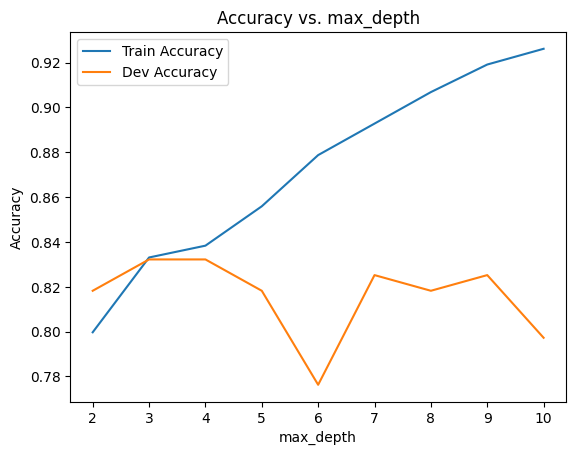

In [12]:
plt.plot(range(2, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(2, 11), dev_accuracies, label='Dev Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. max_depth')
plt.legend()
plt.show()

In [13]:
# Find best max_depth
best_depth = range(2, 11)[np.argmax(dev_accuracies)]
print(f"Best max_depth: {best_depth}")

# Retrain on full training data (training + development)
final_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_tree.fit(X_train_full, y_train_full)

# Evaluate on test set
y_test_pred = final_tree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {test_accuracy:.2f}")


Best max_depth: 3
Final Test Accuracy: 0.80
